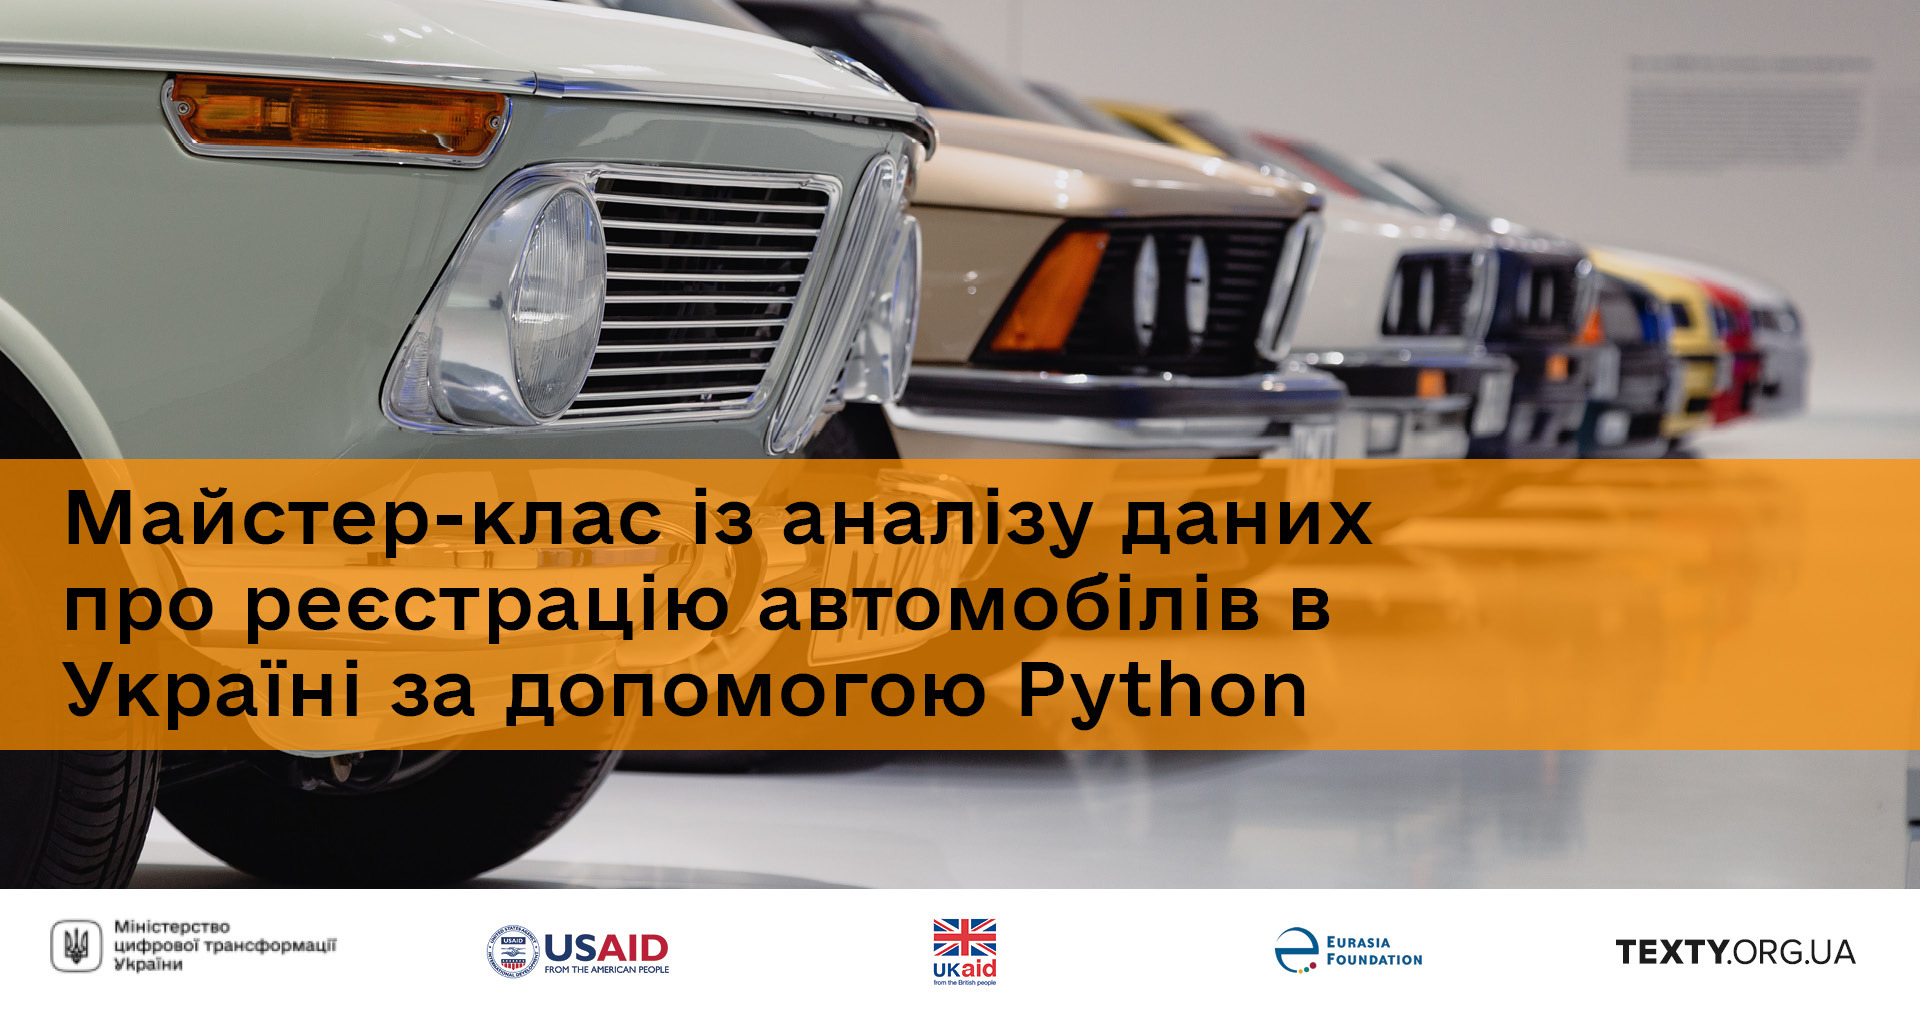

__Що ми хочемо дізнатись:__
    <li> розбивку по областях </li>
    <li> які найпопулярніші марки авто в Україні </li>
    <li> як часто перереєструють автомобілі N року випуску  </li>
    <li> як реєструють електрокари на первинному ринку </li>
    <li> як часто перепродають електрокари </li>

__імпортуємо бібілотеки__

In [1]:
import requests
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint as pp
import re
import seaborn as sns

# Для роботи із .zip файлами
import io
import zipfile
import os 
import csv

# Працюємо із АРІ порталу

__Робимо запит до АРІ Data.gov.ua__
документація по роботі із АРІ Порталу: 
ідентифікаційний номер набору даних по реєстрації авто в Україні: 	06779371-308f-42d7-895e-5a39833375f0
посилання на набір даних: https://data.gov.ua/dataset/06779371-308f-42d7-895e-5a39833375f0

In [5]:
response = requests.get("https://data.gov.ua/api/3/action/package_show?id=06779371-308f-42d7-895e-5a39833375f0").json()
pp(response) #переглядаємо вміст відповіді

{'help': 'https://data.gov.ua/api/3/action/help_show?name=package_show',
 'result': {'archiver': {'is_broken': False,
                         'reason': '',
                         'status': 'Archived successfully',
                         'status_id': 0},
            'author': 'rodger_236',
            'author_email': 'rodger@mvs.gov.ua',
            'creator_user_id': '109cb3b1-5415-4457-8280-f927e9cc5335',
            'groups': [{'description': 'Все що стосується Верховної ради та '
                                       'питань загальнодаржавного характеру',
                        'display_name': 'Держава',
                        'id': '6c734e97-52f5-40a1-9cb5-81b5ebb15e43',
                        'image_display_url': 'https://data.gov.ua/uploads/group/2018-08-09-052819.023276bank-2.svg',
                        'name': 'derzhava',
                        'title': 'Держава'},
                       {'description': 'Арештоване Майно, все про компанії, '
                        

Нам треба знайти дані із атрибутом "url_redirected_to" повний шлях: "["result"]["resources"][_порядковий номер ресурсу_]["url"]"
Отримуємо дані за допомогою циклу, яким перебираємо всі посилання на ресурси у наборі.

In [6]:
for i in response["result"]["resources"]:
    print(i["description"], " :", i["url"])

Дані щодо транспортних засобів за 2018 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/01323740-88df-46c2-b06e-fbb58c89fe17/download/tz_opendata_z01012018_po01012019.zip
Дані щодо транспортних засобів за 2017 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/9ce32352-bd11-4324-a2b4-5addbd228b1b/download/tz_opendata_z01012017_po31122017.zip
Дані щодо транспортних засобів за 2016 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/7bdc2a1b-5399-4ab0-97e0-633e68837b04/download/tz_opendata_z01012016_po31122016.zip
Дані щодо транспортних засобів за 2015 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/09c606dc-d740-40db-96f0-e679eeca6ace/download/tz_opendata_z01012015_po31122015.zip
Дані щодо транспортних засобів за 2014 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/80a115ae-61df-4a13-8771-36c2826268df/download/tz_opendata_z01012014_

In [7]:
urls = [i["url"] for i in response["result"]["resources"]]
urls

['https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/01323740-88df-46c2-b06e-fbb58c89fe17/download/tz_opendata_z01012018_po01012019.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/9ce32352-bd11-4324-a2b4-5addbd228b1b/download/tz_opendata_z01012017_po31122017.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/7bdc2a1b-5399-4ab0-97e0-633e68837b04/download/tz_opendata_z01012016_po31122016.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/09c606dc-d740-40db-96f0-e679eeca6ace/download/tz_opendata_z01012015_po31122015.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/80a115ae-61df-4a13-8771-36c2826268df/download/tz_opendata_z01012014_po31122014.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/86a9548b-8323-4fa2-972e-0692edf6959f/download/tz_opendata_z01012013_po31122013.zip',
 'https://data.gov.ua/dataset/0ffd

In [9]:
os.mkdir("data")

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'data'

In [10]:
for url in urls:
    response = requests.get(url)
    zip_data = io.BytesIO(response.content)
    # розпаковуємо архів із даними
    print("zip_data = io.BytesIO(rs.content)")
    with zipfile.ZipFile(zip_data) as zip_file:
        print("zip_file.extractall")
        zip_file.extractall("data")

zip_data = io.BytesIO(rs.content)
zip_file.extractall
zip_data = io.BytesIO(rs.content)
zip_file.extractall
zip_data = io.BytesIO(rs.content)
zip_file.extractall
zip_data = io.BytesIO(rs.content)
zip_file.extractall
zip_data = io.BytesIO(rs.content)
zip_file.extractall
zip_data = io.BytesIO(rs.content)
zip_file.extractall
zip_data = io.BytesIO(rs.content)
zip_file.extractall
zip_data = io.BytesIO(rs.content)
zip_file.extractall
zip_data = io.BytesIO(rs.content)
zip_file.extractall


Отримуємо перелік всіх файлів в директорії

In [3]:
directory = os.listdir("data")
directory

['tz_opendata_z01012013_po31122013.csv',
 'tz_opendata_z01012014_po31122014.csv',
 'tz_opendata_z01012015_po31122015.csv',
 'tz_opendata_z01012016_po31122016.csv',
 'tz_opendata_z01012017_po31122017.csv',
 'tz_opendata_z01012018_po01012019.csv',
 'tz_opendata_z01012019_po01012020.csv',
 'tz_opendata_z01012020_po01012021.csv',
 'tz_opendata_z01012021_po01042021.csv']

# Підвантажєння та підготовка даних

## Перекодовуємо інформацію про області та сервісні центри

In [25]:
# тестуємо завантаження даних
data = pd.read_csv("data/tz_opendata_z01012013_po31122013.csv", error_bad_lines = False, sep = ";", )

In [ ]:
data = pd.DataFrame()
for f in directory:
    table = pd.read_csv("data/"+ str(f), error_bad_lines = False, sep = ";")
    data = pd.concat([data, table])
data

In [ ]:
data.columns

In [4]:
# правильний спосіб завантаження даних в pandas, якщов они зберігаються у кількох таблицях
data = pd.DataFrame()
for f in directory:
    table = pd.read_csv("data/"+ str(f), error_bad_lines = False, sep = ";")
    table.columns = table.columns.str.lower() #у деяких старих наборах даних заголовки колонок великими літерами
    data = pd.concat([data, table])
data

c:\users\dhuba\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\dhuba\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,person,reg_addr_koatuu,oper_code,oper_name,d_reg,dep_code,dep,brand,model,make_year,color,kind,body,purpose,fuel,capacity,own_weight,total_weight,n_reg_new
0,P,5.101370e+08,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-01-16,1305301,ВІННИЦЬКИЙ ВРЕР УДАІ УМВС УКРАЇНИ У ВІННИЦЬКІ...,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2696.0,2069.0,2550.0,АВ1923ВТ
1,P,5.110137e+09,230,230 - ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КО...,2013-08-29,5146,Центр 5146,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,2362.0,1720.0,2450.0,ВН8542СО
2,P,2.310137e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-02-02,1242,Центр 1242,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1245.0,1720.0,АР6199СІ
3,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-26,6141,Центр 6141,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,1560.0,1736.0,2661.0,ВО5930ВА
4,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-05,6141,Центр 6141,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2148.0,1995.0,3500.0,ВО5562ВА
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443461,P,NaN,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ ПО ПОСВ...,05.03.2021,12373,ТСЦ 6843,SKODA,OCTAVIA COMBI,2002,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1295,1805,ВХ8612ЕО
443462,P,5.104000e+08,308,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПI...,16.03.2021,12231,ТСЦ 0543,HYUNDAI,SANTA FE,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ5529НО
443463,P,5.101000e+08,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ ПО ПОСВ...,05.03.2021,12229,ТСЦ 0541,HYUNDAI,SANTA FE,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ0875НТ
443464,P,NaN,308,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПI...,30.03.2021,12250,ТСЦ 1443,FORD,C-MAX,2014,БІЛИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ЕЛЕКТРО АБО БЕНЗИН,2000.0,1674,2250,АН4178ОН


In [ ]:
data.columns

Дані із кодами КОАТУУ - частково не заповнені, ми не хочемо втратити інформацію про жодну зареєстровану дію, тому ми не будемо використовувати дані із атрибуту data["reg_addr_koatuu"], натомість ми геокодуємо дані з інформації про орган, який здійснював реєстраційні дії. Але ці дані доволі брудні, також під час формування набору у 2013 - 2015 роках проховодилась реформа, що призвело до того, що ми маємо інформацію про різні орагни реєстраці. Сучасні органи кодуються у форматі ТСЦ ххуу - де хх - код регіону, а уу - унікальний код сервісного центру. 
Завантажимо таблицю, яка містить інформацію про сучасну прив'язку ТСЦ до областей та виведемо її, для цього треба налаштувати Pandas

In [8]:
# встановлення обмеження на кількість відображених рядків
pd.set_option('display.max_rows', 160)
 
# скидання обмеження на кількість відображених атрибутів
pd.set_option('display.max_columns', None)
 
# встановлення обмеження на кількість відображених символів в комірці
pd.set_option('display.max_colwidth', 25)

In [ ]:
# читаємо таблицю
deps = pd.read_excel("dep.xlsx")

In [ ]:
# виводимо її на екран
deps

In [24]:
# дублюємо колонку із даними про департаменти для подальшого кодування регіонів
data["region"] = data["dep"]

In [29]:
# зводимо все до нижнього регістру
data["region"] = data["region"].str.lower()

# стандартизуємо дані із назвами сервісних центрів

data["region"] = data["region"].str.replace(r"\((\d{4})\).*", r"тсц \1", regex=True)
# Для быльшої зрозумілості виокремити області вирішив через окремі ітерації
data["region"] = data["region"].str.replace(r".*макарі.*|.*київсь.*", r"київська", regex=True)
data["region"] = data["region"].str.replace(r".*чернівець.*", r"чернівецька", regex=True)
data["region"] = data["region"].str.replace(r".*херсон.*", r"херсонська", regex=True)
data["region"] = data["region"].str.replace(r".*мог-подільськ.*|.*липовец.*|.*ямпіл.*|.*калинівс.*|.*тульчин.*|.*козятин.*|.*вінниць.*|.*жмерин.*|.*берша.*|.*крижо.*|.*хмільн.*|.*гайсин.*|.*немирів.*", r"вінницька", regex=True)
data["region"] = data["region"].str.replace(r".*донець.*", r"донецька", regex=True)
data["region"] = data["region"].str.replace(r".*тернопіль.*", r"тернопільська", regex=True)
data["region"] = data["region"].str.replace(r".*запорі.*", r"запорізька", regex=True)
data["region"] = data["region"].str.replace(r".*волин.*|.*горохів.*|.*луцьк.*|.*ковел.*|.*ківер.*|.*любом.*|.*кашир.*", r"волинська", regex=True)
data["region"] = data["region"].str.replace(r".*дніпропе.*", r"дніпропетровська", regex=True)
data["region"] = data["region"].str.replace(r".*полтав.*", r"полтавська", regex=True)
data["region"] = data["region"].str.replace(r".*чернігів.*", r"чернігівська", regex=True)
data["region"] = data["region"].str.replace(r".*миколаїв.*", r"миколаївська", regex=True)
data["region"] = data["region"].str.replace(r".*житомир.*|.*овруц.*|.*овруч.*|.*коростен.*|.*чудні.*|.*попільня.*|.*бердичі.*|.*радомиш.*", r"житомирська", regex=True)
data["region"] = data["region"].str.replace(r".*львів.*", r"львівська", regex=True)
data["region"] = data["region"].str.replace(r".*черкас.*", r"черкаська", regex=True)
data["region"] = data["region"].str.replace(r".*івано.*", r"івано-Франківська", regex=True)
data["region"] = data["region"].str.replace(r".*харків.*", r"харківська", regex=True)
data["region"] = data["region"].str.replace(r".*рівне.*", r"рівненська", regex=True)
data["region"] = data["region"].str.replace(r".*сум.*", r"сумська", regex=True)
data["region"] = data["region"].str.replace(r".*нетіши.*", r"хмельницька", regex=True)
data["region"] = data["region"].str.replace(r".*іршав.*|.*міжгірсь.*|.*виноградів.*|.*тячів.*|.*сваляв.*|.*берегів.*|.*берегов.*|.*рахів.*|.*ужгород.*|.*мукаче.*|.*мукачів.*|.*хуст.*", r"закарпатська", regex=True)
data["region"] = data["region"].str.replace(r".*м\. кіровсь.*|.*луганс.*|.*лутуг.*", r"луганська", regex=True)
data["region"] = data["region"].str.replace(r".*м\. київ.*|.*києв.*|.*головний.*|.*міністерство.*", r"київ", regex=True)
data["region"] = data["region"].str.replace(r".*крим.*|.*євпаторія.*|.*судак.*|.*армян.*|.*сімферополь.*|.*симферопіль.*|.*бахчисарай.*", r"крим", regex=True)
data["region"] = data["region"].str.replace(r"центр|тсц даі", r"тсц", regex=True)

In [30]:
# перевіряємо унікальні значення після використання регулярних виразів
pp(data["region"].unique())

array(['вінницька', 'одеська', 'дніпропетровська', 'тернопільська',
       'київ', 'чернівецька', 'луганська', 'донецька', 'харківська',
       'львівська', 'миколаївська', 'запорізька', 'житомирська',
       'херсонська', 'рівненська', 'хмельницька', 'сумська', 'полтавська',
       'крим', 'київська', 'волинська', 'кіровоградська', 'черкаська',
       'тсц 1408', 'закарпатська', 'тсц 1401', 'івано-Франківська',
       'тсц 7401', 'тсц 1402', 'тсц 1403', 'тсц 1416', 'тсц 1411',
       'тсц 1418', 'тсц 1412', 'тсц 7404', 'тсц 7402', 'тсц 7406',
       'тсц 1413', 'тсц 1409', 'тсц 1414', 'тсц 1420', 'тсц 1404',
       'тсц 1405', 'тсц 1406', 'тсц 1419', 'тсц 1410', 'тсц 1417',
       'тсц 7403', 'тсц 1415', 'тсц 7405', 'тсц 1421', 'тсц 1407',
       'тсц 1422', 'овруцьке врер', 'мвс україни', 'чернігівська'],
      dtype=object)


Кодуємо області в тіх записах де відомі номери сервісних центрів

In [31]:
data["region"] = data["region"].str.lower()
data["region"] = data["region"].str.replace(r"тсц 05.*", r"вінницька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 07.*", r"волинська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 12.*", r"дніпропетровська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 14.*", r"донецька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 18.*", r"житомирська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 21.*", r"закарпатська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 23.*", r"запорізька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 26.*", r"івано-Франківська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 32.*", r"київська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 35.*", r"кіровоградська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 44.*", r"луганська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 46.*", r"львівська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 48.*", r"миколаївська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 51.*", r"одеська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 53.*", r"полтавська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 56.*", r"рівненська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 59.*", r"сумська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 61.*", r"тернопільська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 63.*", r"харківська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 65.*", r"херсонська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 68.*", r"хмельницька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 71.*", r"черкаська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 73.*", r"чернівецька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 74.*", r"чернігівська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 80.*", r"київ", regex=True)
data["region"] = data["region"].str.replace(r"тсц 85.*|тсц 01.*", r"крим", regex=True) # кодуємо дані спільно для Криму та Сімферополя
data["region"] = data["region"].str.replace(r"мвс україни.*", r"київ", regex=True)

In [47]:
# Перевіряємо чи все ок із регіонами
data["region"].unique()

array(['вінницька', 'одеська', 'дніпропетровська', 'тернопільська',
       'київ', 'чернівецька', 'луганська', 'донецька', 'харківська',
       'львівська', 'миколаївська', 'запорізька', 'житомирська',
       'херсонська', 'рівненська', 'хмельницька', 'сумська', 'полтавська',
       'крим', 'київська', 'волинська', 'кіровоградська', 'черкаська',
       'закарпатська', 'івано-франківська', 'чернігівська'], dtype=object)

In [49]:
# Зберігаємо дані у файл
data.to_csv("data_normalize.csv")

## Підвантажуємо "чистий" набір із даними

In [5]:
# Завантажуємо дані із файлу
data = pd.read_csv("data_normalize.csv", low_memory = False)
data.head()

,Unnamed: 0,person,reg_addr_koatuu,oper_code,oper_name,d_reg,dep_code,dep,brand,model,...,color,kind,body,purpose,fuel,capacity,own_weight,total_weight,n_reg_new,region
0,0,P,5.101370e+08,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-01-16,1305301,ВІННИЦЬКИЙ ВРЕР УДАІ УМВС УКРАЇНИ У ВІННИЦЬКІ...,SSANG YONG REXTON,REXTON,...,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2696.0,2069.0,2550.0,АВ1923ВТ,вінницька
1,1,P,5.110137e+09,230,230 - ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КО...,2013-08-29,5146,Центр 5146,TOYOTA PREVIA,PREVIA,...,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,2362.0,1720.0,2450.0,ВН8542СО,одеська
2,2,P,2.310137e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-02-02,1242,Центр 1242,SKODA OCTAVIA,OCTAVIA,...,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1245.0,1720.0,АР6199СІ,дніпропетровська
3,3,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-26,6141,Центр 6141,CITROEN JUMPY,JUMPY,...,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,1560.0,1736.0,2661.0,ВО5930ВА,тернопільська
4,4,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-05,6141,Центр 6141,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,...,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2148.0,1995.0,3500.0,ВО5562ВА,тернопільська


Визначаємо пропущені значення - будуємо теплокарту пропущених значень. 

<AxesSubplot:>

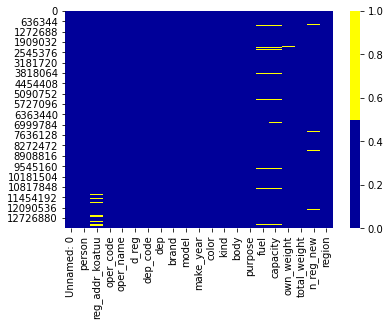

In [4]:
cols = data.columns
# визначаємо кольори
# жовтий - пропущені значення, синій - дійсні значення
colours = ['#000099', '#ffff00'] 
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))

Переглядаємо статистику значень

In [45]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

index - 0%
Unnamed: 0 - 0%
person - 0%
reg_addr_koatuu - 4%
oper_code - 0%
oper_name - 0%
d_reg - 0%
dep_code - 0%
dep - 0%
brand - 0%
model - 0%
make_year - 0%
color - 0%
kind - 0%
body - 0%
purpose - 0%
fuel - 5%
capacity - 6%
own_weight - 1%
total_weight - 0%
n_reg_new - 1%
region - 0%
brand_new - 0%
brand_model - 0%


Будуємо гістограму пропущених значень

created missing indicator for: reg_addr_koatuu
created missing indicator for: fuel
created missing indicator for: capacity
created missing indicator for: own_weight
created missing indicator for: total_weight
created missing indicator for: n_reg_new


<AxesSubplot:xlabel='index'>

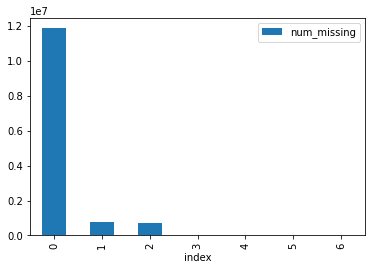

In [57]:
# будуємо індикатор для пропущених значень
for col in data.columns:
    missing = data[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        data['{}_ismissing'.format(col)] = missing


# будуємо гістограму на основі індикатора
ismissing_cols = [col for col in data.columns if 'ismissing' in col]
data['num_missing'] = data[ismissing_cols].sum(axis=1)

data['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

Продовжуємо досліджувати дані

In [7]:
#Перевіряємо види реєстрацій автомобілів
data["oper_name"].unique()

array(['40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬНІЙ ОРГАНІЗАЦІЇ',
       '230 -  ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН ПО ДОРУЧ',
       '400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗАМIНИ НОМЕРНИХ АГРЕГ.',
       '30 - ПЕРВИННА РЕЄСТРАЦІЯ ТЗ ДЛЯ ІНДИВ. ВЛАСНИКА',
       '440 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ВТРАТІ СВIДОЦТВА ПРО РЕЄСТРАЦIЮ',
       '430 - ПЕРЕРЕЄСТРАЦІЯ ПРИ ЗАМІНІ СВІДОЦТВА ПРО РЕЄСТРАЦІЮ',
       '100 - ПЕРВИННА РЕЄСТРАЦIЯ ТЗ ПРИДБАНОГО В ТОРГІВЕЛЬНІЙ ОРГАНІЗАЦІЇ, УСТАНОВИ',
       '70 - РЕЄСТРАЦIЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ',
       '401 - ПЕРЕРЕЄСТРАЦІЯ ТЗ ПРИ ПЕРЕОБЛАДНАННІ ІЗ ЗАМІНОЮ КУЗОВА',
       '50 - РЕЄСТРАЦIЯ ТЗ ЗА ДОГОВОРОМ КУПIВЛI-ПРОДАЖУ',
       '11 - ПЕРВИННА РЕЄСТРАЦIЯ ТЗ ДЛЯ ІНШИХ ОРГ. ДЕРЖ.ВЛАСНОСТІ',
       '69 - РЕЄСТРАЦІЯ ТЗ ПО АКТУ ПРИЙОМУ-ПЕРЕДАЧІ',
       '350 - ПЕРЕРЕЄСТРАЦIЯ У ЗВ`ЯЗКУ ЗI ЗМIНОЮ НАЗВИ ОРГАНIЗАЦIЇ',
       '530 - ЗНЯТТЯ З ОБЛIКУ ДЛЯ РЕАЛIЗАЦIЇ',
       '80 - РЕЄСТРАЦIЯ ТЗ ПРИДБАНОГО НА АУКЦІОНІ ТОВАР. БIРЖI',
       '410

In [6]:
# завантажуємо словник із інформацією про реєстраційні дії
oper_name_dict = pd.read_csv("oper_name.csv", sep = ";",encoding = "cp1251" )
oper_name_dict.head()

,oper_code,oper_name_new
0,10,ПЕРВИННА РЕЄСТРАЦIЯ ТЗ ДЛЯ ДЕРЖБЮДЖ. ОРГ.
1,11,ПЕРВИННА РЕЄСТРАЦIЯ ТЗ ДЛЯ ІНШИХ ОРГ. ДЕРЖ.ВЛА...
2,13,ВИПРАВЛЕННЯ VIN
3,14,ВНЕСЕННЯ БЕЗНОМЕРНОГО ТЗ (ТІЛЬКИ ДЛЯ ВИДАЧІ ДО...
4,15,ВНЕСЕННЯ БЕЗНОМЕРНОГО ТЗ (ТІЛЬКИ ДЛЯ ВИБРАКОВКИ)


In [7]:
# додаємо очищені дані про реєстраційні дії до основного датасету
oper_name_dict["oper_code"] = oper_name_dict["oper_code"].astype(str)
data["oper_code"] = data["oper_code"].astype(str)
data = pd.merge(data,oper_name_dict, on='oper_code',how='left')
data

,Unnamed: 0,person,reg_addr_koatuu,oper_code,oper_name,d_reg,dep_code,dep,brand,model,...,kind,body,purpose,fuel,capacity,own_weight,total_weight,n_reg_new,region,oper_name_new
0,0,P,5.101370e+08,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-01-16,1305301,ВІННИЦЬКИЙ ВРЕР УДАІ УМВС УКРАЇНИ У ВІННИЦЬКІ...,SSANG YONG REXTON,REXTON,...,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2696.0,2069.0,2550.0,АВ1923ВТ,вінницька,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ..."
1,1,P,5.110137e+09,230,230 - ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КО...,2013-08-29,5146,Центр 5146,TOYOTA PREVIA,PREVIA,...,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,2362.0,1720.0,2450.0,ВН8542СО,одеська,ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН
2,2,P,2.310137e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-02-02,1242,Центр 1242,SKODA OCTAVIA,OCTAVIA,...,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1245.0,1720.0,АР6199СІ,дніпропетровська,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ..."
3,3,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-26,6141,Центр 6141,CITROEN JUMPY,JUMPY,...,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,1560.0,1736.0,2661.0,ВО5930ВА,тернопільська,NaN
4,4,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-05,6141,Центр 6141,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,...,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2148.0,1995.0,3500.0,ВО5562ВА,тернопільська,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13366354,443461,P,NaN,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ ПО ПОСВ...,05.03.2021,12373,ТСЦ 6843,SKODA,OCTAVIA COMBI,...,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1295,1805,ВХ8612ЕО,хмельницька,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З
13366355,443462,P,5.104000e+08,308,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПI...,16.03.2021,12231,ТСЦ 0543,HYUNDAI,SANTA FE,...,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ5529НО,вінницька,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПIВЛI
13366356,443463,P,5.101000e+08,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ ПО ПОСВ...,05.03.2021,12229,ТСЦ 0541,HYUNDAI,SANTA FE,...,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ0875НТ,вінницька,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З
13366357,443464,P,NaN,308,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПI...,30.03.2021,12250,ТСЦ 1443,FORD,C-MAX,...,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ЕЛЕКТРО АБО БЕНЗИН,2000.0,1674,2250,АН4178ОН,донецька,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПIВЛI


In [117]:
# створюємо новий стовпець із глобальним статусом
data["oper_name_new"] = data["oper_name_new"].str.replace(r'.*ЗНЯТТЯ.*', r"ЗНЯТТЯ", regex = True)
data["oper_name_new"] = data["oper_name_new"].str.replace(r'.*ПЕРВИННА.*', r"ПЕРВИННА", regex = True)

KeyboardInterrupt: 

# Аналіз

In [ ]:
Завантажуємо дані пілся OpenRefine
та проводимо left join many-to-one

In [9]:
brand_splited = pd.read_excel("brand_splited.xlsx")
brand_splited = brand_splited[["brand", "brand_new"]]
#brand_splited = brand_splited.set_index("brand_name 1")
brand_splited

,brand,brand_new
0,0,0
1,SSANG YONG REXTON,SSANG YONG
2,TOYOTA PREVIA,TOYOTA
3,SKODA OCTAVIA,SKODA
4,CITROEN JUMPY,CITROEN
...,...,...
35231,FSC,FSC
35232,BULTMANN,BULTMANN
35233,HAKO,HAKO
35234,CTR,CTR


In [10]:
data = pd.merge(data,brand_splited, on='brand',how='left')
data.head()

,Unnamed: 0,person,reg_addr_koatuu,oper_code,oper_name,d_reg,dep_code,dep,brand,model,...,body,purpose,fuel,capacity,own_weight,total_weight,n_reg_new,region,oper_name_new,brand_new
0,0,P,5.101370e+08,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-01-16,1305301,ВІННИЦЬКИЙ ВРЕР УДАІ УМВС УКРАЇНИ У ВІННИЦЬКІ...,SSANG YONG REXTON,REXTON,...,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2696.0,2069.0,2550.0,АВ1923ВТ,вінницька,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ...",SSANG YONG
1,1,P,5.110137e+09,230,230 - ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КО...,2013-08-29,5146,Центр 5146,TOYOTA PREVIA,PREVIA,...,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,2362.0,1720.0,2450.0,ВН8542СО,одеська,ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН,TOYOTA
2,2,P,2.310137e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-02-02,1242,Центр 1242,SKODA OCTAVIA,OCTAVIA,...,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1245.0,1720.0,АР6199СІ,дніпропетровська,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ...",SKODA
3,3,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-26,6141,Центр 6141,CITROEN JUMPY,JUMPY,...,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,1560.0,1736.0,2661.0,ВО5930ВА,тернопільська,NaN,CITROEN
4,4,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-05,6141,Центр 6141,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,...,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2148.0,1995.0,3500.0,ВО5562ВА,тернопільська,NaN,MERCEDES-BENZ


### топ __нових__ реєстрацій автомобілів за маркою

In [11]:
data.reset_index(inplace = True)

In [53]:
# робимо сабсет даних для візуалізації
barplot_brands = data[["brand_new","oper_code","person", "kind", "make_year"]]
barplot_brands = barplot_brands.loc[
    barplot_brands["oper_code"].isin(["30", "100", "11", "20", "10", "120", "99", "172", "105", "17"])] # фільтруємо ті реєстраційні операції, які нам потрібні

barplot_brands = barplot_brands.loc[
    barplot_brands["person"] == "P"] # вибираємо тип покупця, в даному випадку фізичні особи

barplot_brands = barplot_brands.loc[
    barplot_brands["kind"] == "ЛЕГКОВИЙ"] # вибираємо тип автомобіля

barplot_brands = barplot_brands.loc[
    barplot_brands["make_year"] >= 2000] # обираємо рік випуску автомобіля

# робимо зведену таблицю для простоти візуалізації
barplot_brands = pd.pivot_table(barplot_brands, index = "brand_new", aggfunc="count")
barplot_brands = barplot_brands.sort_values("oper_code", ascending = False) #сортуємо дані в порядку спадання

Посилання на документацію https://seaborn.pydata.org/generated/seaborn.barplot.html

In [54]:
# індекс, який ми отримали через сводну таблицю, для того щоб побудувати графік (при зміні налаштувань графіка застосовується лише раз)
barplot_brands.reset_index(inplace = True)

[Text(0.5, 1.0, 'Рейтинг найпопулярніших марок авто в Україні')]

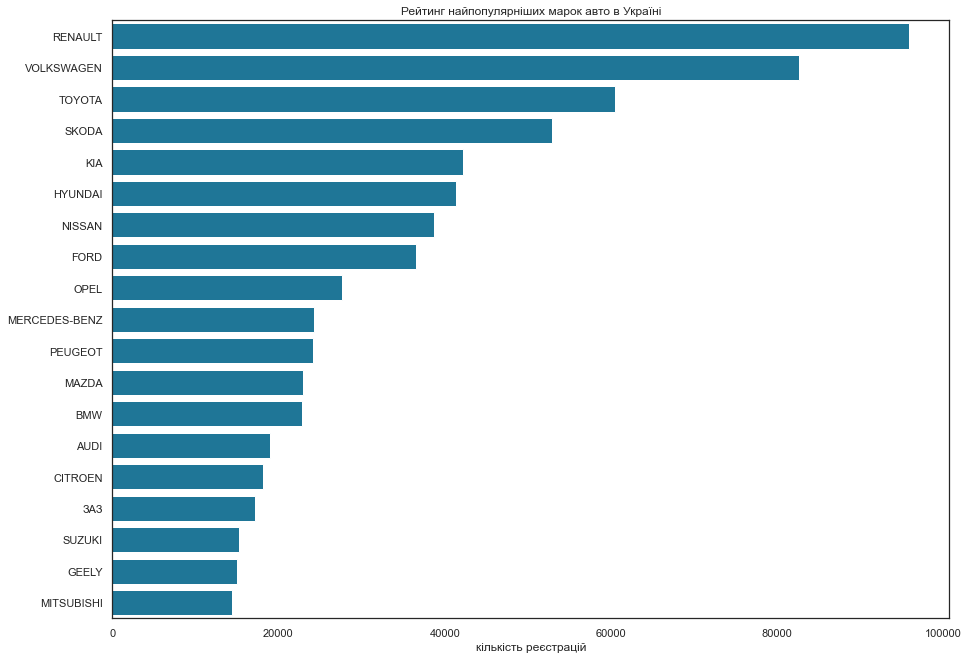

In [55]:
barplot = sns.barplot(
    data=barplot_brands.iloc[:19], # Кількість записів у ТОП, можемо редагувати під час оголошення графіку
    x="oper_code",
    y = "brand_new",
    color="#0b7fab",
)

sns.set_theme(
    style = "white",
    rc={'figure.figsize':(15,11)}
)

barplot.set(xlabel ='кількість реєстрацій', ylabel='')
barplot.set(title = "Рейтинг найпопулярніших марок авто в Україні")

### топ __нових__ реєстрацій автомобілв за моделлю фізичні особи

In [24]:
# об'єднуємо стовпчик "марка" та "модель" для отримання унікальних записів
data["brand_model"] = data[["brand_new", "model"]].apply(tuple, axis=1)
data.head()

,index,Unnamed: 0,person,reg_addr_koatuu,oper_code,oper_name,d_reg,dep_code,dep,brand,...,purpose,fuel,capacity,own_weight,total_weight,n_reg_new,region,oper_name_new,brand_new,brand_model
0,0,0,P,5.101370e+08,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-01-16,1305301,ВІННИЦЬКИЙ ВРЕР УДАІ УМВС УКРАЇНИ У ВІННИЦЬКІ...,SSANG YONG REXTON,...,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2696.0,2069.0,2550.0,АВ1923ВТ,вінницька,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ...",SSANG YONG,"(SSANG YONG, REXTON)"
1,1,1,P,5.110137e+09,230,230 - ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КО...,2013-08-29,5146,Центр 5146,TOYOTA PREVIA,...,ЗАГАЛЬНИЙ,БЕНЗИН,2362.0,1720.0,2450.0,ВН8542СО,одеська,ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН,TOYOTA,"(TOYOTA, PREVIA)"
2,2,2,P,2.310137e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-02-02,1242,Центр 1242,SKODA OCTAVIA,...,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1245.0,1720.0,АР6199СІ,дніпропетровська,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ...",SKODA,"(SKODA, OCTAVIA)"
3,3,3,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-26,6141,Центр 6141,CITROEN JUMPY,...,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,1560.0,1736.0,2661.0,ВО5930ВА,тернопільська,NaN,CITROEN,"(CITROEN, JUMPY)"
4,4,4,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-05,6141,Центр 6141,MERCEDES-BENZ SPRINTER 313 CDI,...,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2148.0,1995.0,3500.0,ВО5562ВА,тернопільська,NaN,MERCEDES-BENZ,"(MERCEDES-BENZ, SPRINTER 313 CDI)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13366354,13366354,443461,P,NaN,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ ПО ПОСВ...,05.03.2021,12373,ТСЦ 6843,SKODA,...,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1295,1805,ВХ8612ЕО,хмельницька,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З,SKODA,"(SKODA, OCTAVIA COMBI)"
13366355,13366355,443462,P,5.104000e+08,308,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПI...,16.03.2021,12231,ТСЦ 0543,HYUNDAI,...,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ5529НО,вінницька,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПIВЛI,HYUNDAI,"(HYUNDAI, SANTA FE)"
13366356,13366356,443463,P,5.101000e+08,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ ПО ПОСВ...,05.03.2021,12229,ТСЦ 0541,HYUNDAI,...,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ0875НТ,вінницька,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З,HYUNDAI,"(HYUNDAI, SANTA FE)"
13366357,13366357,443464,P,NaN,308,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПI...,30.03.2021,12250,ТСЦ 1443,FORD,...,ЗАГАЛЬНИЙ,ЕЛЕКТРО АБО БЕНЗИН,2000.0,1674,2250,АН4178ОН,донецька,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПIВЛI,FORD,"(FORD, C-MAX)"


In [35]:
model_j = pd.pivot_table(data, index = "brand_model", aggfunc="count")
model_j = model_j.sort_values("body", ascending = False)
model_j.head()

,Unnamed: 0,body,brand,brand_new,capacity,color,d_reg,dep,dep_code,fuel,...,n_reg_new,oper_code,oper_name,oper_name_new,own_weight,person,purpose,reg_addr_koatuu,region,total_weight
brand_model,,,,,,,,,,,,,,,,,,,,,
"(DAEWOO, LANOS)",240167,240167,240167,240167,240081,240167,240167,240167,240167,239915,...,239914,240167,240167,207518,239490,240167,240167,230998,240167,240065
"(VOLKSWAGEN, PASSAT)",219817,219817,219817,219817,219779,219817,219817,219817,219817,219667,...,219540,219817,219817,210586,218979,219817,219817,205085,219817,219514
"(VOLKSWAGEN, TRANSPORTER)",186803,186803,186803,186803,186777,186803,186803,186803,186803,186803,...,186688,186803,186803,163584,184776,186803,186803,182802,186803,186681
"(RENAULT, KANGOO)",168295,168295,168295,168295,166343,168295,168295,168295,168295,168275,...,168223,168295,168295,145501,167281,168295,168295,163264,168295,168228
"(CHEVROLET, AVEO)",165171,165171,165171,165171,165156,165171,165171,165171,165171,165170,...,165064,165171,165171,144536,164724,165171,165171,158883,165171,165118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(ЕТАЛОН, T-713.35)",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"(MERCEDES-BENZ, ACTROS 2644LS)",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"(MERCEDES-BENZ, ACTROS 2663LS)",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [36]:
# треба скинути індекс, який ми отримали через сводну таблицю, для того щоб побудувати графік (при зміні налаштувань графіка застосовується лише раз)
model_j.reset_index(inplace = True)

[Text(0.5, 0, 'Кількість реєстрацій'), Text(0, 0.5, '')]

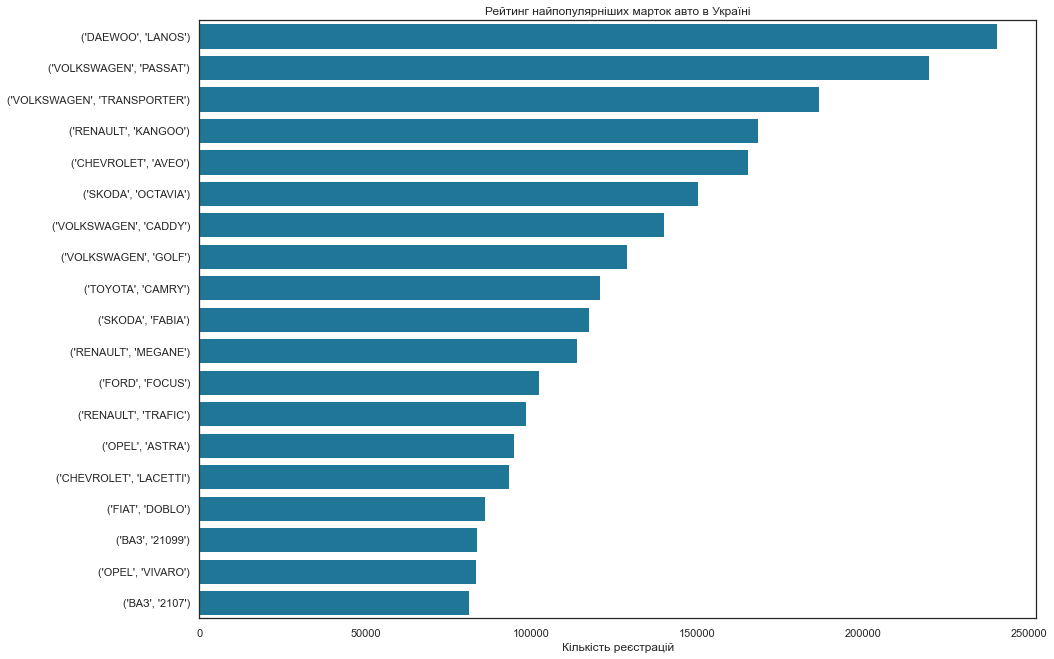

In [43]:
barplot = sns.barplot(
    data=model_j.iloc[:19], # Кількість записів у ТОП, можемо редагувати під час оголошення графіку
    x="body",
    y = "brand_model",
    color="#0b7fab",
)

sns.set_theme(
    style = "white",
    rc={'figure.figsize':(15,11)}
)

barplot.set(title = "Рейтинг найпопулярніших моделей авто в Україні")
barplot.set(xlabel ='Кількість реєстрацій', ylabel='')

### Порівняння на лайнчарті кількості __нових__ реєстрацій АВТО за весь час з 2013 року (накопичення)

In [129]:
linechart_registrations = data[["brand_new","oper_code","person", "kind", "d_reg"]]
linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str)
linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"])
linechart_registrations = linechart_registrations.loc[
    linechart_registrations["oper_code"].isin(["30", "100", "11", "20", "10", "99", "172", "105", "17"])] # фільтруємо ті реєстраційні операції, які нам потрібні

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["person"] == "P"] # вибираємо тип покупця, в даному випадку фізичні особи

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["kind"] == "ЛЕГКОВИЙ"] # вибираємо тип автомобіля

linechart_registrations = pd.pivot_table(linechart_registrations, index = "d_reg",aggfunc="count" )
linechart_registrations['cum_sum'] = linechart_registrations['brand_new'].cumsum()
linechart_registrations.reset_index(inplace = True)

<ipython-input-129-7fb87686b195>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str)
<ipython-input-129-7fb87686b195>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"])


[Text(0.5, 0, ''), Text(0, 0.5, '')]

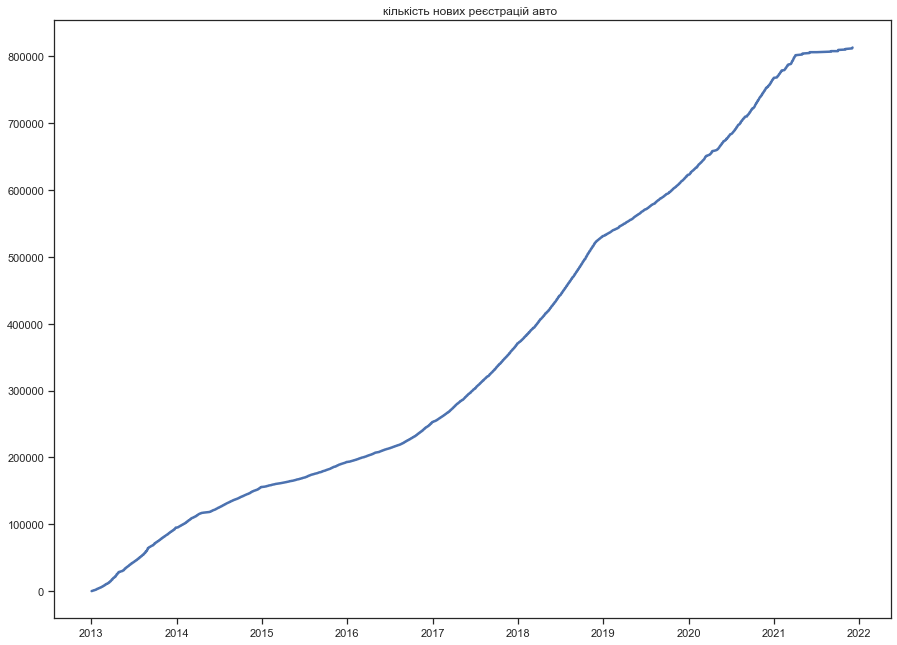

In [130]:
lines = sns.lineplot(data=linechart_registrations, x = "d_reg", y = "cum_sum", linewidth=2.5)
lines.set(title = "кількість нових реєстрацій авто ")
lines.set(xlabel ='', ylabel='')

In [137]:
linechart_registrations = data[["brand_new","oper_code", "person", "kind", "d_reg", "oper_name_new"]] # створюємо копію із датасету з потрібними полями 

linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str) # змінюємо тип коду реєстрації на текстовий

linechart_registrations["oper_name_new"] = linechart_registrations["oper_name_new"].astype(str) # змінюємо тип коду реєстрації на текстовий

linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"]) # перетвлрюємо дату реєстрації на дату
linechart_registrations = linechart_registrations.loc[
    linechart_registrations["oper_code"].isin([
        "30", "100", "11", "20", "10", "99",
        "172", "105", "17", "552", "553", "53", "536",
        "542", "570", "500", "554", "580", "560", "510",
        "535", "534", "540", "550", "561", "520", "532",
        "531", "533", "530"])] # фільтруємо ті реєстраційні операції, які нам потрібні

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["person"] == "P"] # вибираємо тип покупця, в даному випадку фізичні особи

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["kind"] == "ЛЕГКОВИЙ"] # вибираємо тип автомобіля

linechart_registrations = pd.pivot_table(linechart_registrations, index = ["oper_name_new", "d_reg"] ,aggfunc="count" ) # створюємо зведену таблицю
linechart_registrations['cum_sum'] = linechart_registrations['brand_new'].cumsum() # створюємо стовпич із кумулятивною сумою
linechart_registrations.reset_index(inplace = True) # прибераємо індекс


<ipython-input-137-58c06ddef5f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str) # змінюємо тип коду реєстрації на текстовий
<ipython-input-137-58c06ddef5f0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["oper_name_new"] = linechart_registrations["oper_name_new"].astype(str) # змінюємо тип коду реєстрації на текстовий
<ipython-input-137-58c06ddef5f0>:7: SettingWithCopyWarning: 
A value is tryi

In [138]:
linechart_registrations

,oper_name_new,d_reg,brand_new,kind,oper_code,person,cum_sum
0,ЗНЯТТЯ,2013-01-02,370,370,370,370,370
1,ЗНЯТТЯ,2013-01-03,720,720,720,720,1090
2,ЗНЯТТЯ,2013-01-04,525,525,525,525,1615
3,ЗНЯТТЯ,2013-01-05,457,457,457,457,2072
4,ЗНЯТТЯ,2013-01-07,2,2,2,2,2074
...,...,...,...,...,...,...,...
5072,ПЕРВИННА,2021-11-02,575,575,575,575,1920013
5073,ПЕРВИННА,2021-11-03,860,860,860,860,1920873
5074,ПЕРВИННА,2021-12-01,875,875,875,875,1921748
5075,ПЕРВИННА,2021-12-02,538,538,538,538,1922286


[Text(0.5, 0, ''), Text(0, 0.5, '')]

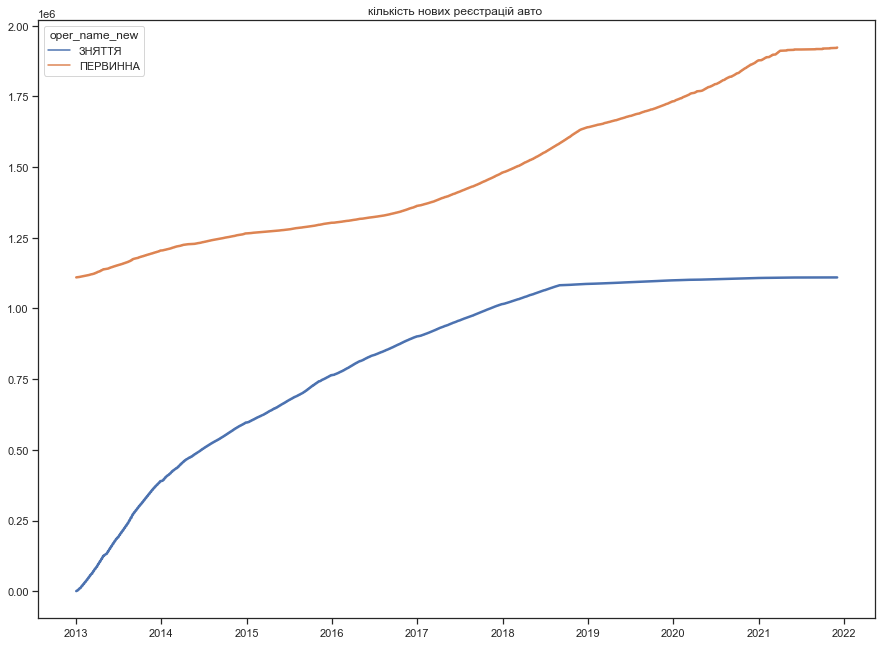

In [139]:
lines = sns.lineplot(data=linechart_registrations, x = "d_reg", y = "cum_sum", linewidth=2.5, hue="oper_name_new")
lines.set(title = "кількість нових реєстрацій авто ")
lines.set(xlabel ='', ylabel='')

### Сітка лайн чартів із порівнянням кількості __нових__ реєстрацій по областях

In [156]:
# Create a dataset with many short random walks
linechart_registrations = data[["brand_new","oper_code","person", "kind", "d_reg", "region"]]
linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str)
linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"])

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["oper_code"].isin(["30", "100", "11", "20", "10", "120", "99"])] # фільтруємо ті реєстраційні операції, які нам потрібні

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["person"] == "P"] # вибираємо тип покупця, в даному випадку фізичні особи

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["kind"] == "ЛЕГКОВИЙ"] # вибираємо тип автомобіля

linechart_registrations = pd.pivot_table(linechart_registrations, index = ["d_reg", "region"],aggfunc="count" )
linechart_registrations

<ipython-input-156-6f73622f9502>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str)
<ipython-input-156-6f73622f9502>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"])


brand_new  kind  oper_code  person
d_reg      region                                               
2013-01-02 вінницька                  8     8          8       8
           дніпропетровська           5     5          5       5
           донецька                  39    39         39      39
           житомирська                2     2          2       2
           закарпатська               1     1          1       1
...                                 ...   ...        ...     ...
2021-12-03 хмельницька               17    17         17      17
           черкаська                 10    10         10      10
           чернівецька                9     9          9       9
           чернігівська              19    19         19      19
           івано-франківська         11    11         11      11

[44087 rows x 4 columns]

In [157]:
# треба скинути індекс, який ми отримали через сводну таблицю, для того щоб побудувати графік (при зміні налаштувань графіка застосовується лише раз)
linechart_registrations.reset_index(inplace = True)
linechart_registrations

,d_reg,region,brand_new,kind,oper_code,person
0,2013-01-02,вінницька,8,8,8,8
1,2013-01-02,дніпропетровська,5,5,5,5
2,2013-01-02,донецька,39,39,39,39
3,2013-01-02,житомирська,2,2,2,2
4,2013-01-02,закарпатська,1,1,1,1
...,...,...,...,...,...,...
44082,2021-12-03,хмельницька,17,17,17,17
44083,2021-12-03,черкаська,10,10,10,10
44084,2021-12-03,чернівецька,9,9,9,9
44085,2021-12-03,чернігівська,19,19,19,19


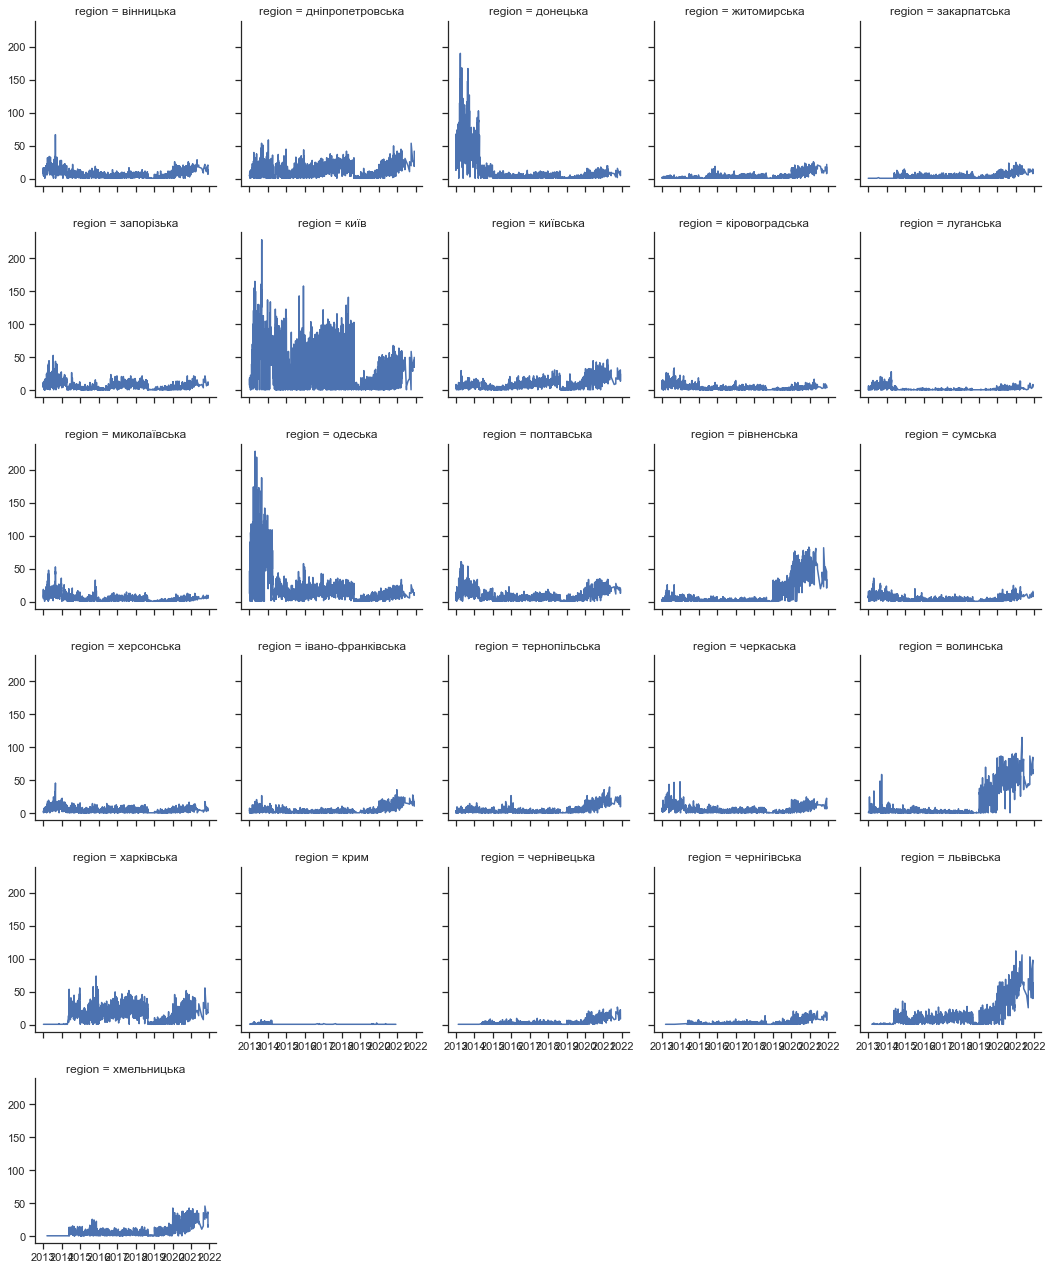

In [160]:
# ініціюємо сітку графіків для кожного регіону
grid = sns.FacetGrid(linechart_registrations, col="region", col_wrap=5, height=3)

grid.map(plt.plot, "d_reg", "brand_new")
grid.set(xlabel ='', ylabel='')

### Хронологія __нових__ та __повторних__ реєстрації електрокарів